
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [4]:
MONTH = 21
YEAR = 252

## Load Data

In [5]:
DATA_STORE = '../data/stock_prices.h5'

In [6]:
factors = (pd.read_hdf(DATA_STORE, 'model_data').sort_index())

In [7]:
factors.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1279525 entries, ('A', Timestamp('2007-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 48 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1279025 non-null  float64
 1   ret_03       1278025 non-null  float64
 2   ret_05       1277025 non-null  float64
 3   ret_10       1274525 non-null  float64
 4   ret_21       1269025 non-null  float64
 5   ret_42       1258525 non-null  float64
 6   ret_63       1248025 non-null  float64
 7   ret_126      1216525 non-null  float64
 8   ret_252      1153525 non-null  float64
 9   ret_fwd      1279525 non-null  float64
 10  BB_UP        1270025 non-null  float64
 11  BB_LOW       1270025 non-null  float64
 12  BB_SQUEEZE   1270025 non-null  float64
 13  HT           1248025 non-null  float64
 14  SAR          1279025 non-null  float64
 15  ADX          1266025 non-null  float64
 16  ADXR         12595

To get all features, we'll select the columns NOT containing forward returns:

In [8]:
fwd_returns = factors.filter(like='fwd').columns
features = factors.columns.difference(fwd_returns).tolist()

In [9]:
features

['AARONOSC',
 'AD',
 'ADOSC',
 'ADX',
 'ADXR',
 'ALPHA_252',
 'ALPHA_63',
 'ATR',
 'BB_LOW',
 'BB_SQUEEZE',
 'BB_UP',
 'BOP',
 'CCI',
 'CMA_252',
 'CMA_63',
 'HML_252',
 'HML_63',
 'HT',
 'MACD',
 'MACD_HIST',
 'MACD_SIGNAL',
 'MARKET_252',
 'MARKET_63',
 'MFI',
 'OBV',
 'PPO',
 'RMW_252',
 'RMW_63',
 'RSI',
 'SAR',
 'SMB_252',
 'SMB_63',
 'STOCH',
 'STOCHRSI',
 'ULTOSC',
 'WILLR',
 'month',
 'ret_01',
 'ret_03',
 'ret_05',
 'ret_10',
 'ret_126',
 'ret_21',
 'ret_252',
 'ret_42',
 'ret_63',
 'weekday']

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

In [10]:
corr_common = factors.drop(fwd_returns, axis=1).corr(method='spearman')

Based on [this](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) example from the seaborn [docs](https://seaborn.pydata.org/index.html).

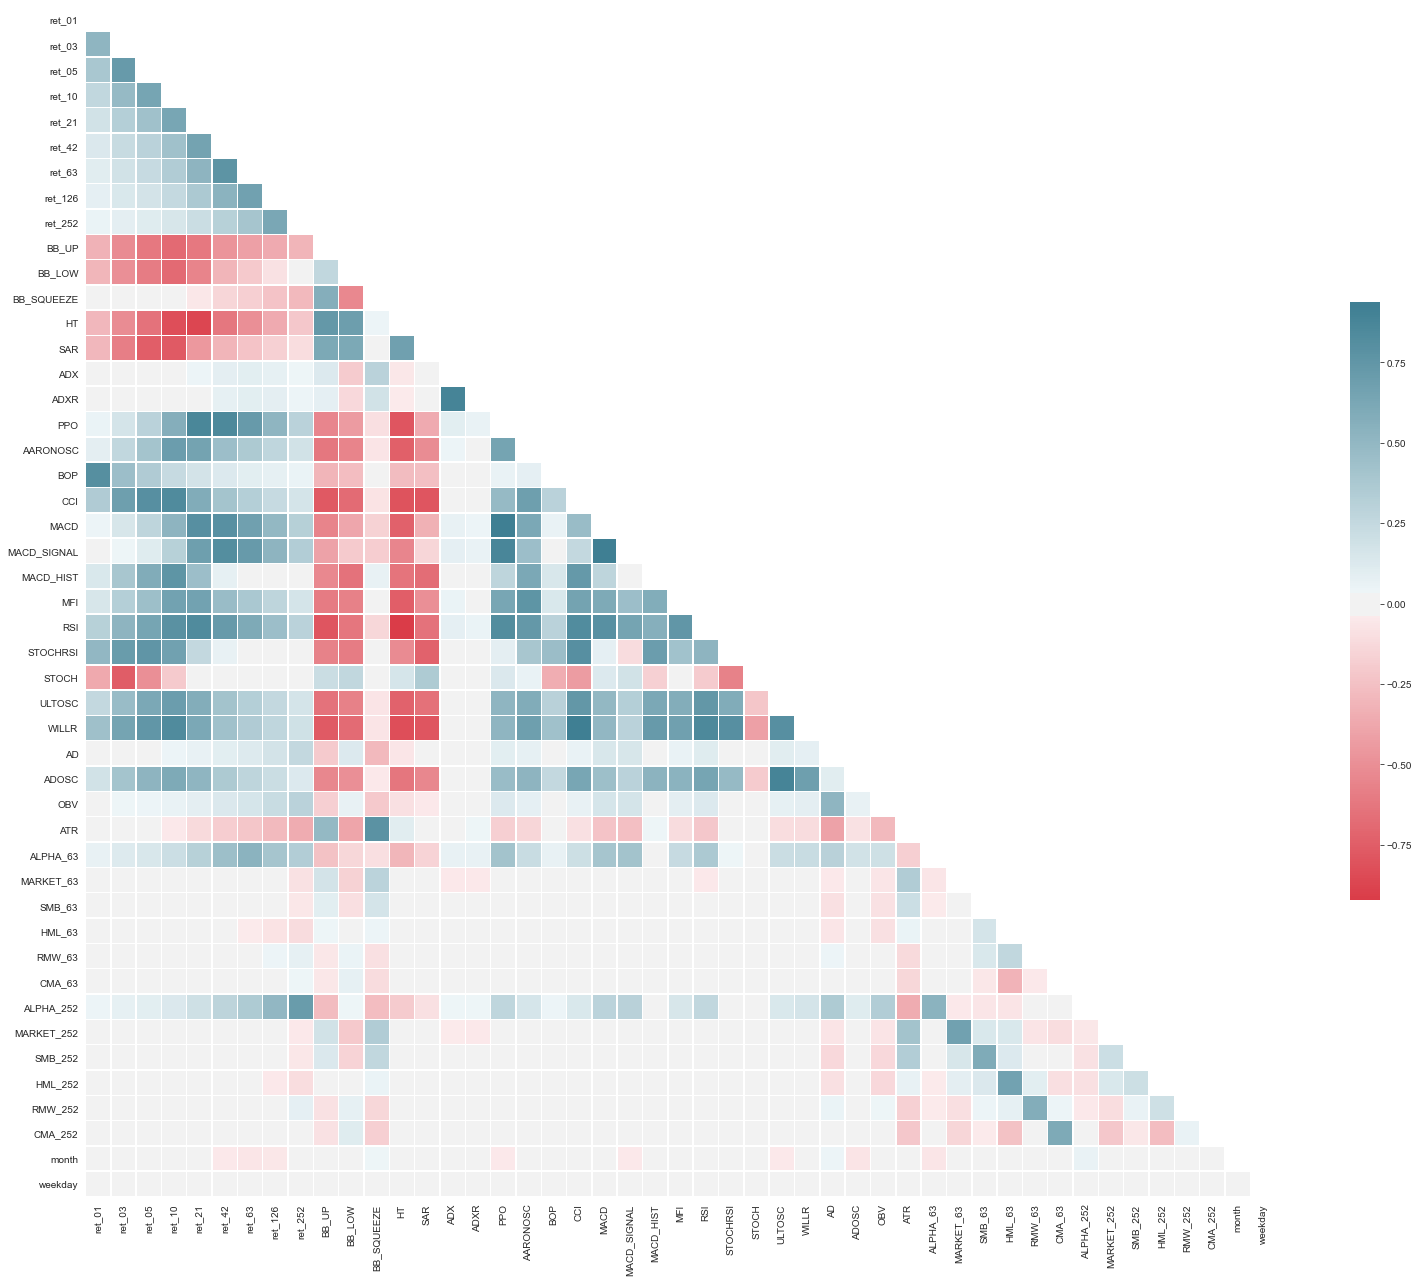

In [11]:
mask = np.triu(np.ones_like(corr_common, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_common, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout();

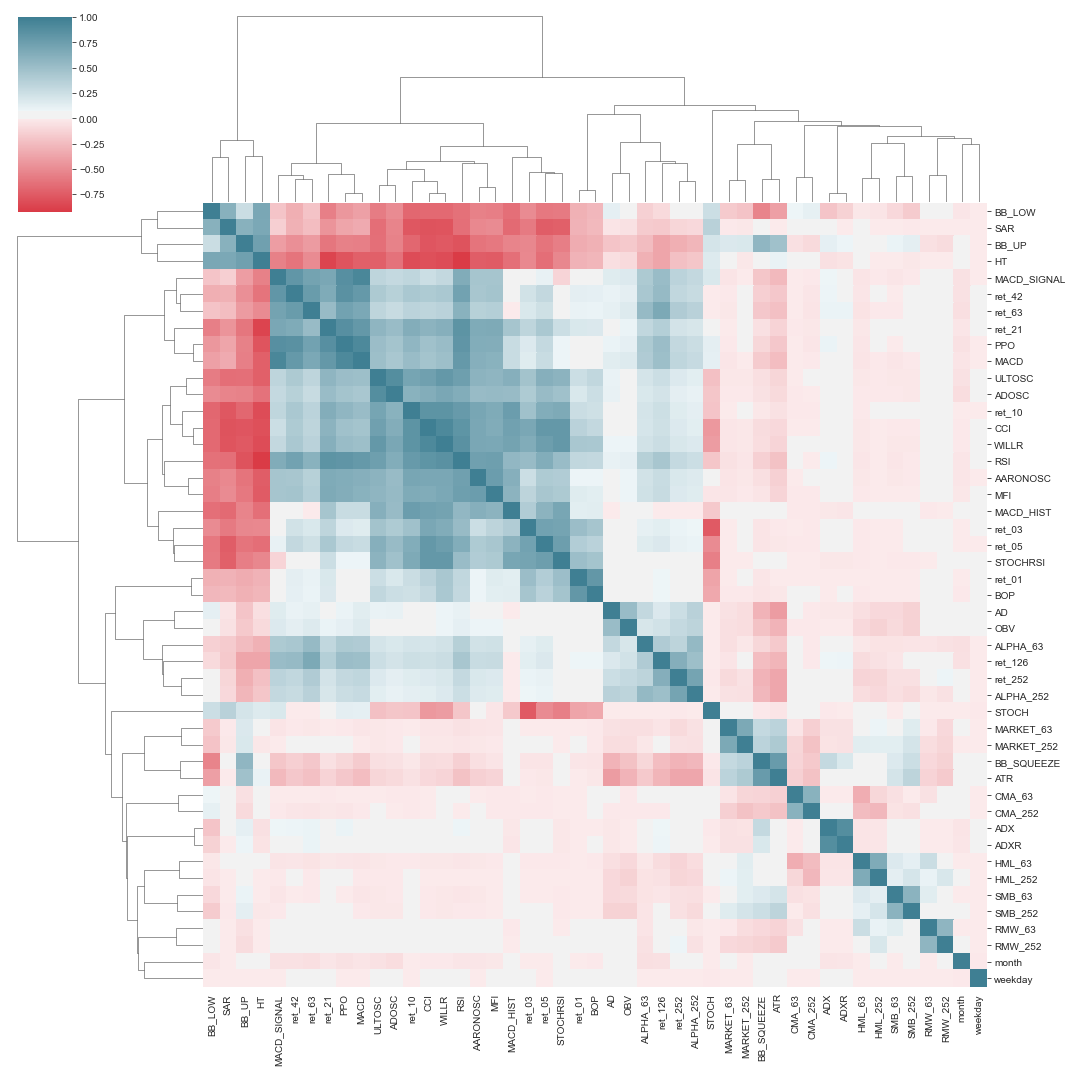

In [12]:
g = sns.clustermap(corr_common, cmap=cmap, figsize=(15, 15))

To inspect the correlation matrix, let's isolate the unique values from the corrlation matrix, excluding the diagonal:

In [13]:
corr_ = corr_common.stack().reset_index() # move column labels to rows as 2nd MultiIndex level
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1 != corr_.x2].drop_duplicates('rho')

### Top ten most correlated features

Select highest and lowest five correlation values:

In [14]:
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
961,MACD,MACD_SIGNAL,0.935901
772,PPO,MACD,0.924741
921,CCI,WILLR,0.924124
1299,ULTOSC,ADOSC,0.885755
673,ADX,ADXR,0.885203
588,HT,RSI,-0.923125
200,ret_21,HT,-0.866332
153,ret_10,HT,-0.827737
592,HT,WILLR,-0.825672
583,HT,CCI,-0.806104


## Forward return correlation

Which features are most correlated with the forward returns?

In [15]:
fwd_corr = factors.drop(['ret_fwd'], axis=1).corrwith(factors.ret_fwd, method='spearman')

In [16]:
fwd_corr = fwd_corr.dropna()
fwd_corr.to_csv('forward_correlation.csv')

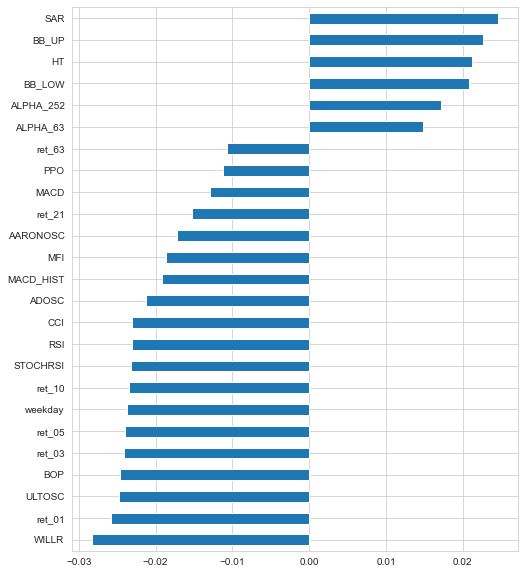

In [17]:
top50 = fwd_corr.abs().nlargest(25).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(8, 10),
                                            legend=False);

## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation.

In [18]:
mi = {}
for feature in features:
    print(feature)
    df = (factors
          .loc[:, ['ret_fwd', feature]]
          .dropna()
          .sample(n=100000))
    discrete_features = df[feature].nunique() < 20
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.ret_fwd,
                                         discrete_features=discrete_features)[0]

AARONOSC
AD
ADOSC
ADX
ADXR
ALPHA_252
ALPHA_63
ATR
BB_LOW
BB_SQUEEZE
BB_UP
BOP
CCI
CMA_252
CMA_63
HML_252
HML_63
HT
MACD
MACD_HIST
MACD_SIGNAL
MARKET_252
MARKET_63
MFI
OBV
PPO
RMW_252
RMW_63
RSI
SAR
SMB_252
SMB_63
STOCH
STOCHRSI
ULTOSC
WILLR
month
ret_01
ret_03
ret_05
ret_10
ret_126
ret_21
ret_252
ret_42
ret_63
weekday


In [19]:
mi = pd.Series(mi)
mi.to_csv('mutual_info.csv')

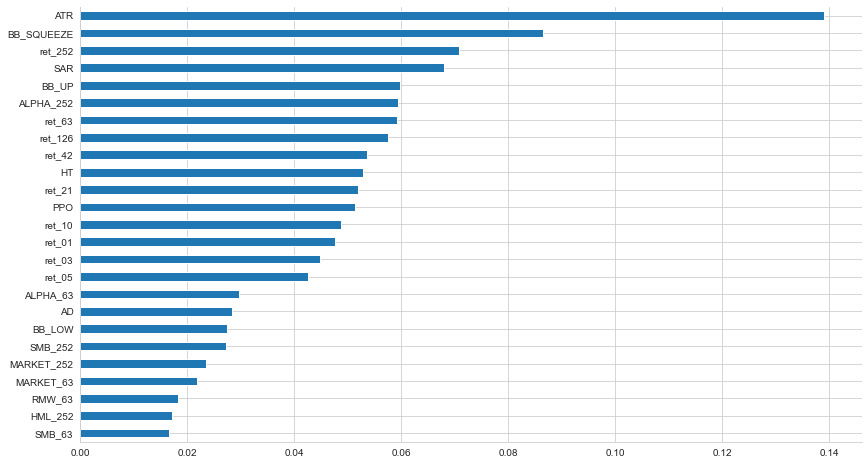

In [20]:
mi.nlargest(25).sort_values().plot.barh(figsize=(14,8))
sns.despine();

## LightGBM Feature Importance

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 3.

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [21]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


In [22]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [23]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [24]:
categoricals = ['month', 'weekday']

In [31]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [32]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
              device='gpu', # uncomment if using GPU
              max_bins=63,  # uncomment if using GPU
              metric='None')

In [33]:
num_boost_round = 5000

In [34]:
lgb_data = lgb.Dataset(data=factors.loc[:, features],
                       label=factors[fwd_returns],
                       categorical_feature=categoricals,
                       free_raw_data=False)

In [35]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

In [36]:
for train_idx, test_idx in cv.split(X=factors):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.118635	valid's ic: 0.0172144
[200]	train's ic: 0.146046	valid's ic: 0.0202788
[300]	train's ic: 0.161081	valid's ic: 0.0261842
[400]	train's ic: 0.172122	valid's ic: 0.027139
[500]	train's ic: 0.187596	valid's ic: 0.0307261
[600]	train's ic: 0.198516	valid's ic: 0.0310815
[700]	train's ic: 0.206822	valid's ic: 0.0306031
[800]	train's ic: 0.21484	valid's ic: 0.029592
[900]	train's ic: 0.221034	valid's ic: 0.0293457
[1000]	train's ic: 0.226635	valid's ic: 0.0292118
Early stopping, best iteration is:
[586]	train's ic: 0.196858	valid's ic: 0.0316471


In [37]:
model = lgb.Booster(model_file='lgb_model.txt')

In [38]:
# select test features and label
test_set = factors.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, fwd_returns[0]]

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'{ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_std/daily_ic_mean: 5.2} | {daily_ic_median: 6.2%}')

 3.16% |  2.87% |   5.5 |  2.65%


In [39]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [40]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

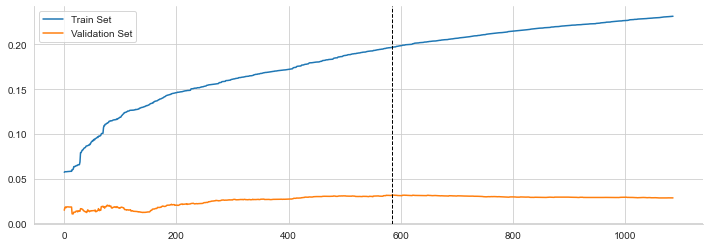

In [41]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

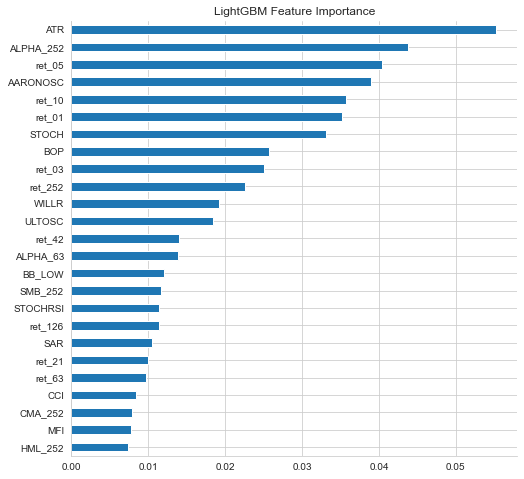

In [42]:
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

In [43]:
shap.initjs()

In [44]:
model = lgb.Booster(model_file='lgb_model.txt')

In [45]:
explainer = shap.TreeExplainer(model)

In [46]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [47]:
shap_values = explainer.shap_values(factors.iloc[test_idx, :].loc[:, model.feature_name()])

In [48]:
np.save('shap_values.npy', shap_values)

In [49]:
shap_values = np.load('shap_values.npy')

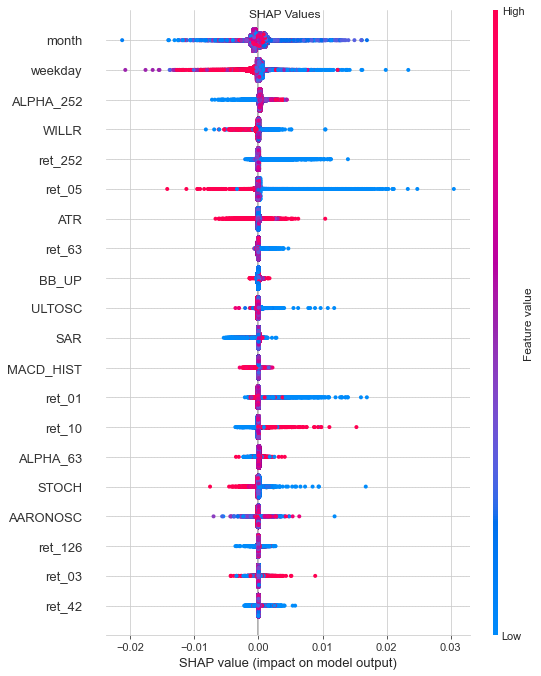

In [50]:
shap.summary_plot(shap_values,
                  factors
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [51]:
shap_values = pd.DataFrame(shap_values, columns=features)

In [52]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [53]:
shap_summary.nlargest(20)

month        0.237695
weekday      0.147539
ALPHA_252    0.109970
WILLR        0.048801
ret_252      0.048132
ret_05       0.041975
ATR          0.029852
ret_63       0.024790
BB_UP        0.023344
ULTOSC       0.022824
SAR          0.022602
MACD_HIST    0.020156
ret_01       0.019486
ret_10       0.017330
ALPHA_63     0.016671
STOCH        0.014431
AARONOSC     0.014198
ret_126      0.013799
ret_03       0.013635
ret_42       0.010123
dtype: float64

In [54]:
shap_summary.to_csv('shap_values.csv')

## Comparison

In [55]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0, squeeze=True)

In [56]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

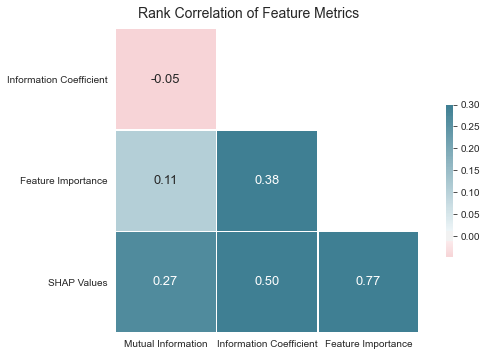

In [57]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

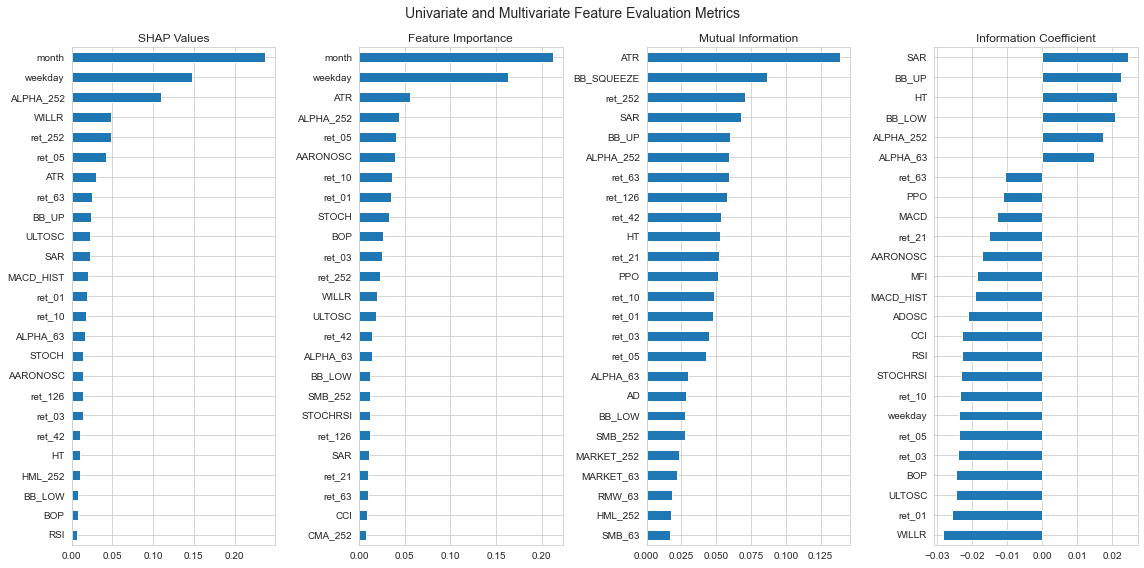

In [58]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

In [59]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [60]:
top_ranked.to_csv('top_features.csv')

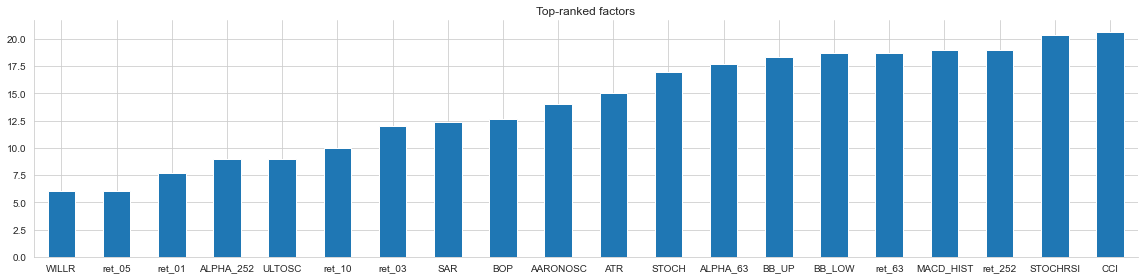

In [61]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.tight_layout();

## Alphalens Analysis

See Alphalens [docs](https://quantopian.github.io/alphalens/) for additional detail.

In [62]:
tickers = factors.index.unique('ticker')

### Get trade prices

In [63]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [64]:
trade_prices = get_trade_prices(tickers)

In [65]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 11.5 MB


### Select factor

In [66]:
alpha = 'ATR'

In [67]:
factor = (factors[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

In [68]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 2.5% entries from factor data: 2.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1240100 entries, (Timestamp('2007-01-23 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1240100 non-null  float64
 1   5D               1240100 non-null  float64
 2   11D              1240100 non-null  float64
 3   factor           1240100 non-null  float64
 4   factor_quantile  1240100 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 52.1+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000989,0.077305,0.017762,0.008468,248396,20.030320
2,0.011341,0.092648,0.023091,0.011038,247880,19.988711
3,0.013172,0.109388,0.027635,0.013704,247698,19.974034
4,0.015620,0.139873,0.033460,0.017125,247880,19.988711
5,0.019062,1.141389,0.049391,0.031495,248246,20.018224


Returns Analysis


,1D,5D,11D
Ann. alpha,-0.023,-0.024,-0.023
beta,0.510,0.545,0.538
Mean Period Wise Return Top Quantile (bps),2.033,1.770,1.418
Mean Period Wise Return Bottom Quantile (bps),-1.671,-1.545,-1.332
Mean Period Wise Spread (bps),3.704,3.095,2.548


Information Analysis


,1D,5D,11D
IC Mean,-0.012,-0.006,-0.002
IC Std.,0.257,0.263,0.252
Risk-Adjusted IC,-0.046,-0.024,-0.009
t-stat(IC),-2.316,-1.199,-0.444
p-value(IC),0.021,0.231,0.657
IC Skew,-0.077,-0.075,-0.076
IC Kurtosis,-0.295,-0.428,-0.366


Turnover Analysis


,1D,5D,11D
Quantile 1 Mean Turnover,0.048,0.125,0.185
Quantile 2 Mean Turnover,0.110,0.281,0.401
Quantile 3 Mean Turnover,0.123,0.314,0.441
Quantile 4 Mean Turnover,0.100,0.264,0.380
Quantile 5 Mean Turnover,0.040,0.108,0.161


,1D,5D,11D
Mean Factor Rank Autocorrelation,0.995,0.969,0.938


<Figure size 432x288 with 0 Axes>

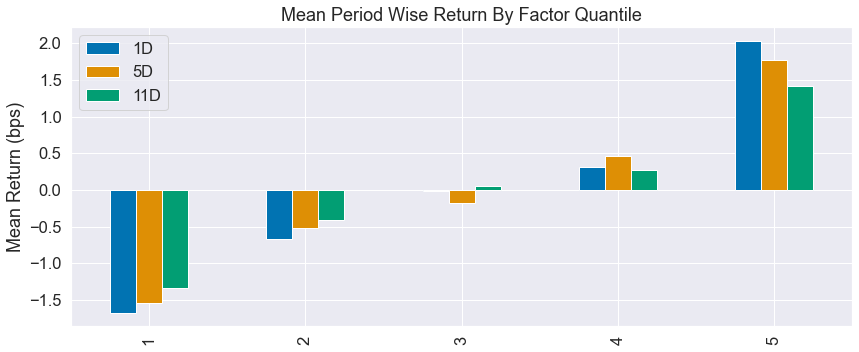

In [69]:
create_summary_tear_sheet(factor_data)